# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives
5. Applicants that are married
6. Applicants that are female
7. Applicants with longer loan terms.

Which applicants are less likely to get a loan
1. Applicants with higher dependents, as they may have increased financial obligations.
2. Applicants with a low income-to-loan ratio, even if they have a co-applicant
3. Applicants who are self-employed, as they may have less stable income and higher perceived risk.
4. Applicants who have not provided accurate and complete documentation
5. Applicants with a shorter loan amount term (Loan_Amount_Term) that may result in higher monthly payments and financial strain.
6. Applicants without a good credit history


## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder


df = pd.read_csv("/Users/brittanyharding/LHL-Projects/Mini-Project/data/data-2.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [40]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Look at some basic statistics for numerical variables.

In [41]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.

Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [42]:
# Get the number of unique values in each nominal variable
nominal_variables = ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
unique_value_counts = df[nominal_variables].nunique()

print(unique_value_counts)

Loan_ID           614
Gender              2
Married             2
Dependents          4
Education           2
Self_Employed       2
Credit_History      2
Property_Area       3
Loan_Status         2
dtype: int64


Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

In [43]:
# Exclude Loan_ID variable
nominal_variables = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']

# Calculate frequency of different categories in each nominal variable
for variable in nominal_variables:
    frequency = df[variable].value_counts()
    print(f"Frequency of categories in {variable}:")
    print(frequency)

Frequency of categories in Gender:
Gender
Male      489
Female    112
Name: count, dtype: int64
Frequency of categories in Married:
Married
Yes    398
No     213
Name: count, dtype: int64
Frequency of categories in Dependents:
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
Frequency of categories in Education:
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64
Frequency of categories in Self_Employed:
Self_Employed
No     500
Yes     82
Name: count, dtype: int64
Frequency of categories in Credit_History:
Credit_History
1.0    475
0.0     89
Name: count, dtype: int64
Frequency of categories in Property_Area:
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64
Frequency of categories in Loan_Status:
Loan_Status
Y    422
N    192
Name: count, dtype: int64


### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.

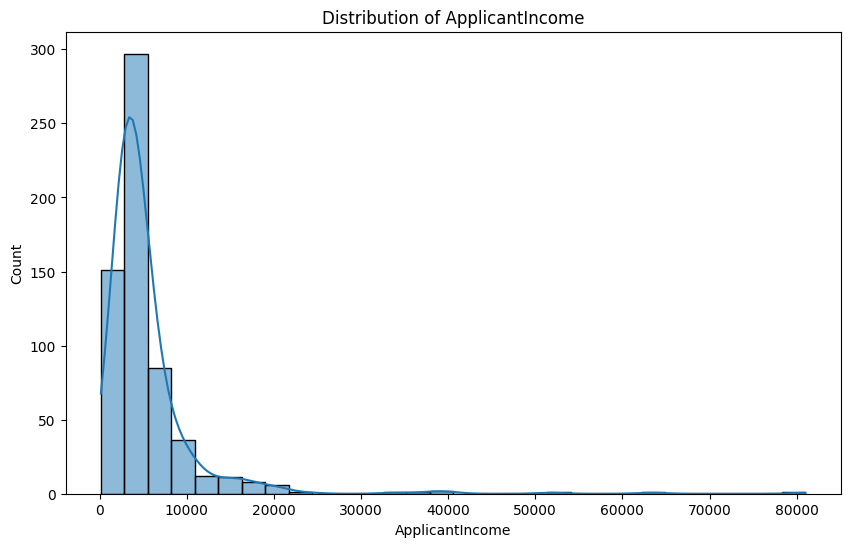

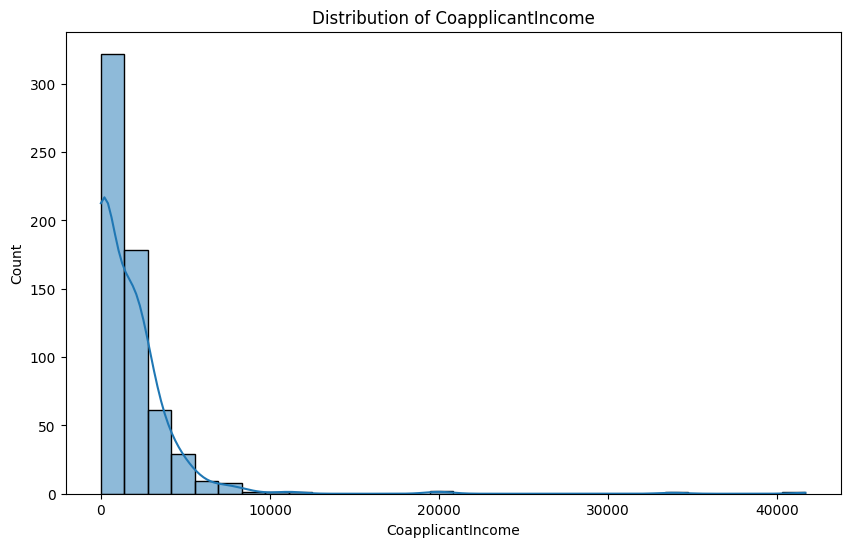

In [44]:
# Plot the distribution of ApplicantIncome
plt.figure(figsize=(10, 6))
sns.histplot(df['ApplicantIncome'], bins=30, kde=True)  
plt.title('Distribution of ApplicantIncome')
plt.xlabel('ApplicantIncome')
plt.ylabel('Count')
plt.show()

# Plot the distribution of CoapplicantIncome
plt.figure(figsize=(10, 6))
sns.histplot(df['CoapplicantIncome'], bins=30, kde=True)  
plt.title('Distribution of CoapplicantIncome')
plt.xlabel('CoapplicantIncome')
plt.ylabel('Count')
plt.show()

##### Upon visual inspection, neither applicant of coapplicant income appear to follow normal distribution

In [45]:
shapiro_results_applicant = shapiro(df['ApplicantIncome'])
print("ApplicantIncome p-value: {:.60f}".format(shapiro_results_applicant.pvalue))

shapiro_results_coapplicant = shapiro(df['CoapplicantIncome'])
print("CoapplicantIncome p-value: {:.60f}".format(shapiro_results_coapplicant.pvalue))

ApplicantIncome p-value: 0.000000000000000000000000000000000000004812613840683294449112
CoapplicantIncome p-value: 0.000000000000000000000000000000000000008946127616988567399679


##### Based on the p-values obtained from the Shapiro-Wilk test for normality, both the ApplicantIncome and CoapplicantIncome variables have extremely small p-values (significantly less than 0.05), indicating strong evidence against the null hypothesis of normality. Hence, we can conclude that these variables do not exhibit a normal distribution.


Look at box plots to understand the distributions. 

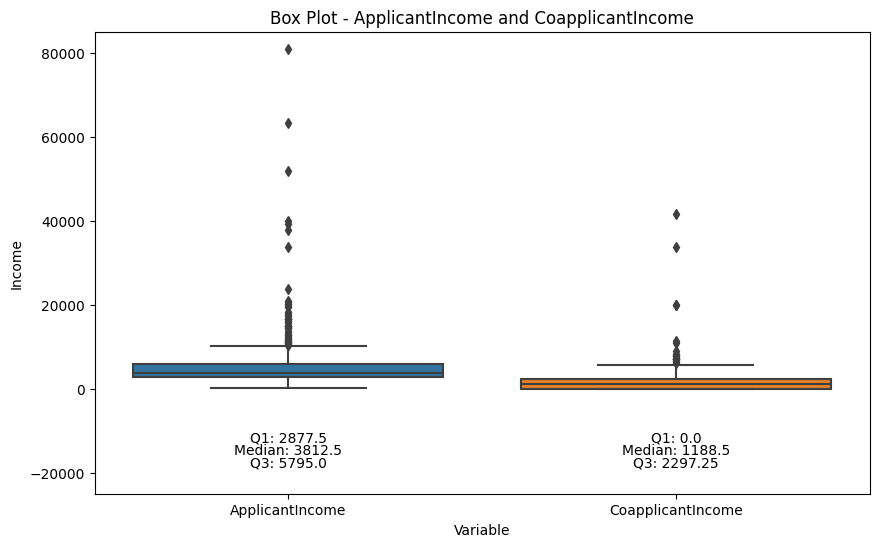

In [46]:
# Create box plots for ApplicantIncome and CoapplicantIncome

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df[['ApplicantIncome', 'CoapplicantIncome']])
plt.title('Box Plot - ApplicantIncome and CoapplicantIncome')
plt.xlabel('Variable')
plt.ylabel('Income')

# Annotate the plot with statistical summary below the box plot
stats = df[['ApplicantIncome', 'CoapplicantIncome']].describe()
for i, col in enumerate(stats.columns):
    stat_values = stats[col].values.round(2)
    plt.text(i, -10000, f'Q1: {stat_values[4]}', ha='center', va='top')
    plt.text(i, -13000, f'Median: {stat_values[5]}', ha='center', va='top')
    plt.text(i, -16000, f'Q3: {stat_values[6]}', ha='center', va='top')

plt.ylim(bottom=-25000)  # Adjust the y-axis limit for annotations
plt.show()

Look at the distribution of income segregated  by `Education`

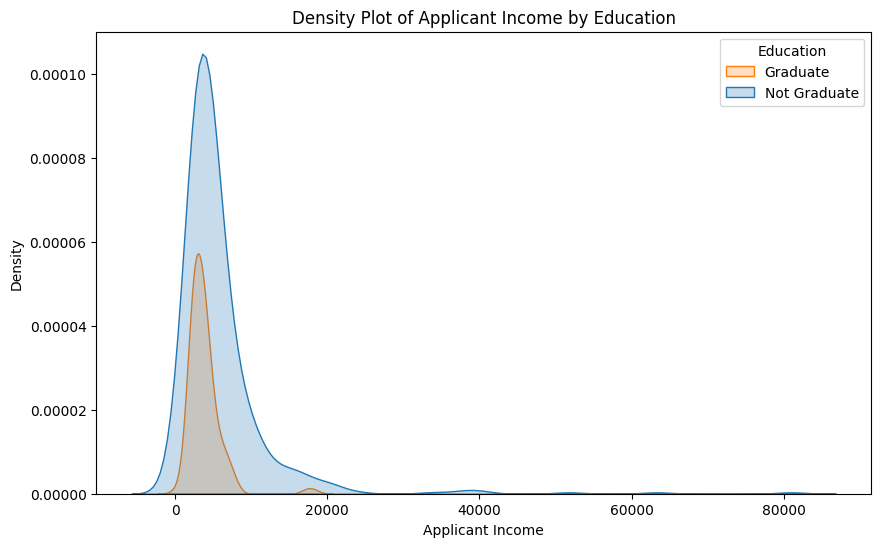

In [47]:
# Create density plots for ApplicantIncome segregated by Education
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='ApplicantIncome', hue='Education', fill=True,
            legend=True)
plt.title('Density Plot of Applicant Income by Education')
plt.xlabel('Applicant Income')
plt.ylabel('Density')
plt.legend(title='Education', labels=['Graduate', 'Not Graduate'])
plt.show()

# Create density plots for CoapplicantIncome segregated by Education
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='CoapplicantIncome', hue='Education', fill=True,
            legend=True)
plt.title('Density Plot of Co-applicant Income by Education')
plt.xlabel('Co-applicant Income')
plt.ylabel('Density')
plt.legend(title='Education', labels=['Graduate', 'Not Graduate'])
plt.show()

Look at the histogram and boxplot of LoanAmount

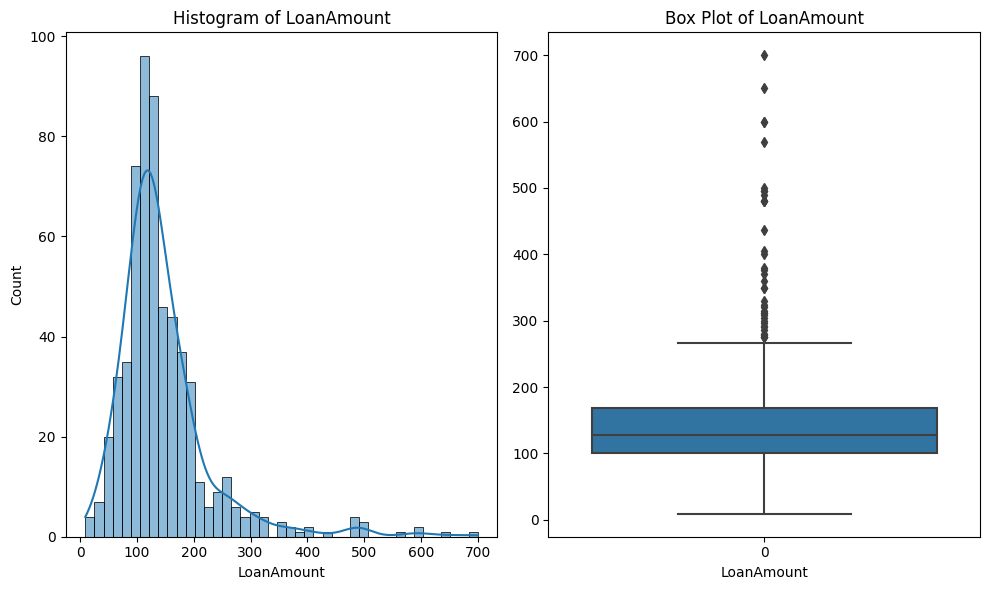

In [48]:
# Histogram of LoanAmount
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['LoanAmount'], kde=True)
plt.title('Histogram of LoanAmount')
plt.xlabel('LoanAmount')
plt.ylabel('Count')

# Box Plot of LoanAmount
plt.subplot(1, 2, 2)
sns.boxplot(df['LoanAmount'])
plt.title('Box Plot of LoanAmount')
plt.xlabel('LoanAmount')
plt.ylabel('')


plt.tight_layout()
plt.show()

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

In [49]:
# Calculate z-scores for ApplicantIncome
z_scores_income = np.abs((df['ApplicantIncome'] - df['ApplicantIncome'].mean()) / df['ApplicantIncome'].std())
# Set z-score threshold for outliers (e.g., z-score > 3)
income_outliers = df[z_scores_income > 3]

# Calculate z-scores for LoanAmount
z_scores_loan = np.abs((df['LoanAmount'] - df['LoanAmount'].mean()) / df['LoanAmount'].std())
# Set z-score threshold for outliers (e.g., z-score > 3)
loan_outliers = df[z_scores_loan > 3]

print("ApplicantIncome outliers:")
print(income_outliers)

print("\nLoanAmount outliers:")
print(loan_outliers)

ApplicantIncome outliers:
      Loan_ID Gender Married Dependents Education Self_Employed   
126  LP001448    NaN     Yes         3+  Graduate            No  \
155  LP001536   Male     Yes         3+  Graduate            No   
171  LP001585    NaN     Yes         3+  Graduate            No   
183  LP001637   Male     Yes          1  Graduate            No   
185  LP001640   Male     Yes          0  Graduate           Yes   
333  LP002101   Male     Yes          0  Graduate           NaN   
409  LP002317   Male     Yes         3+  Graduate            No   
443  LP002422   Male      No          1  Graduate            No   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term   
126            23803                0.0       370.0             360.0  \
155            39999                0.0       600.0             180.0   
171            51763                0.0       700.0             300.0   
183            33846                0.0       260.0             360.0   
185  

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

Pivot Table:
Loan_Status            N    Y
Female                37   75
Male                 150  339
Married: No           79  134
Married: Yes         113  285
Dependents: 0        107  238
Dependents: 1         36   66
Dependents: 2         25   76
Dependents: 3+        18   33
Graduate             140  340
Not Graduate          52   82
Married: No          157  343
Married: Yes          26   56
Credit_History: No    82    7
Credit_History: Yes   97  378
Rural                 69  110
Semiurban             54  179
Urban                 69  133


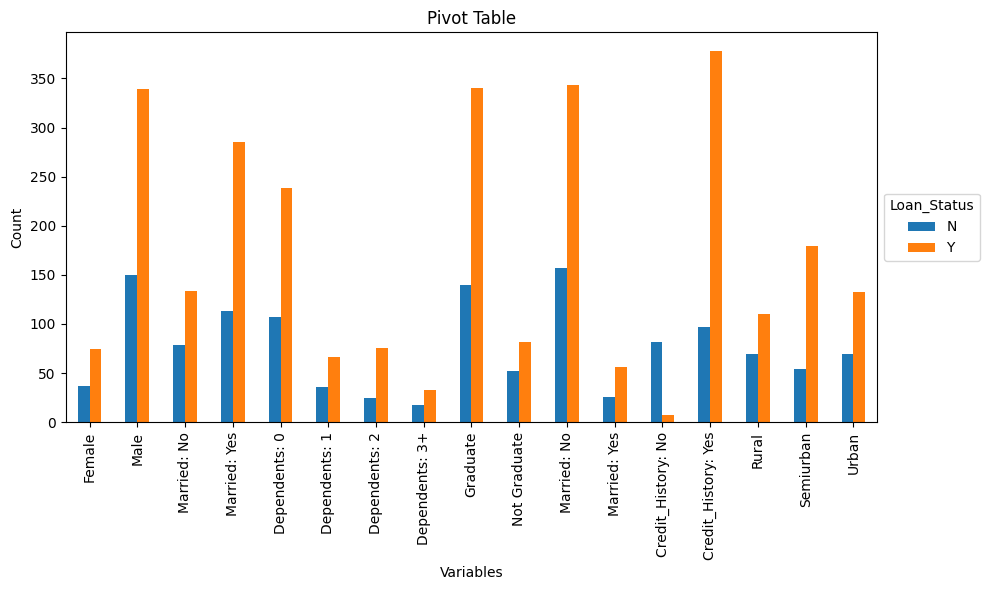

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Create an empty DataFrame to store the pivot table
pivot_table = pd.DataFrame()

# Iterate over each categorical variable and create a line in the pivot table
for variable in nominal_variables:
    if variable != 'Loan_ID' and variable != 'Loan_Status':
        table = df.groupby([variable, 'Loan_Status']).size().unstack().fillna(0)
        pivot_table = pd.concat([pivot_table, table], axis=0)

# Replace numerical values with labels for 'Dependents' variable
dep_labels = {'0': 'Dependents: 0', '1': 'Dependents: 1', '2': 'Dependents: 2', '3+': 'Dependents: 3+'}
pivot_table.rename(index=dep_labels, inplace=True)

# Replace numerical values with labels for 'Married' variable
married_labels = {'Yes': 'Married: Yes', 'No': 'Married: No'}
pivot_table.rename(index=married_labels, inplace=True)

# Replace numerical values with labels for 'Credit_History' variable
credit_labels = {1.0: 'Credit_History: Yes', 0.0: 'Credit_History: No'}
pivot_table.rename(index=credit_labels, inplace=True)

# Replace 'Yes' and 'No' labels with 'Self_Employed' labels
self_employed_labels = {'Yes': 'Self_Employed: Yes', 'No': 'Self_Employed: No'}
pivot_table.rename(index=self_employed_labels, inplace=True)

# Display the pivot table
print("Pivot Table:")
print(pivot_table)

# Plotting the pivot table
pivot_table.plot(kind='bar', figsize=(10, 6))

# Formatting the chart
plt.title("Pivot Table")
plt.xlabel("Variables")
plt.ylabel("Count")
plt.legend(title="Loan_Status", loc='center left', bbox_to_anchor=(1.0, 0.5))

# Display the chart
plt.tight_layout()
plt.show()

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

In [51]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [52]:
# Find rows with NaN values
rows_with_nan = df[df.isna().any(axis=1)]
rows_with_nan

# Find rows with more than 3 NaN values
rows_with_more_than_3_nan = df[df.isna().sum(axis=1) > 3]
rows_with_more_than_3_nan

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


##### Most NaNs are split across rows. Therefore, it does not make sense to drop all rows with NaN, as otherwise we would be losing approx 1/5 of an already small dataset. 

### Pre-Process Data Function
- Where gender is not specified, a third catergory unknown will be imputed. This is because it not possible to determine if it was not filled out as the male or female catergories were not distinct enough to capture gender, or because they did not fill out that section.
- For married, dependents, and self-employed NaN values will be imputed as 0 to avoid biased assumptions, ensuring a neutral and conservative stance until more information is obtained.
- Since dataset is small, I will impute the loan amount and term where Loan status is No as 0 and calculate the remaining values using KNN
- Performing the scaling adjustment of multiplying ApplicantIncome and CoapplicantIncome by 12 to convert them to yearly incomes, and multiplying LoanAmount by 1000 to convert it from thousands to the actual dollar amount, ensures that these variables are on the same scale, facilitating meaningful comparisons and analyses.
- use of Logistic Regression to Impute Credit History

In [53]:
# import pandas as pd
# from sklearn.impute import KNNImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# def preprocess_data(df):
#     # Impute missing values
#     df['Gender'].fillna('Unknown', inplace=True)
#     df['Married'].fillna('No', inplace=True)
#     df['Dependents'].fillna(0, inplace=True)
#     df['Self_Employed'].fillna('No', inplace=True)
#     df['Dependents'] = df['Dependents'].replace({'3+': 3})

#     # Convert 'Gender' column to numeric values
#     df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1, 'Unknown': 2})

#     # Convert 'Married' column to numeric values
#     df['Married'] = df['Married'].replace({'No': 0, 'Yes': 1})

#     # Convert 'Education' column to numeric values
#     df['Education'] = df['Education'].replace({'Not Graduate': 0, 'Graduate': 1})

#     # Convert 'Self_Employed' column to numeric values
#     df['Self_Employed'] = df['Self_Employed'].replace({'No': 0, 'Yes': 1})

#     # Convert 'Dependents' column to numeric values
#     df['Dependents'] = df['Dependents'].astype(int)

#     # Perform one-hot encoding for 'property_area'
#     df_encoded = pd.get_dummies(df['Property_Area'], prefix='property_area')
#     df = pd.concat([df, df_encoded], axis=1)

#     # Impute 0 for LoanAmount and Loan_Amount_Term where Loan_Status is 'N'
#     df.loc[df['Loan_Status'] == 'N', ['LoanAmount', 'Loan_Amount_Term']] = 0

#     # Perform KNN imputation on LoanAmount
#     columns_to_impute = ['LoanAmount']
#     imputer = KNNImputer(n_neighbors=5)
#     df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

#     # Perform KNN imputation on Loan_Amount_Term
#     columns_to_impute = ['Loan_Amount_Term']
#     imputer = KNNImputer(n_neighbors=5)
#     df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

#     # Round 'LoanAmount' and 'Loan_Amount_Term' to the nearest whole number
#     df['LoanAmount'] = df['LoanAmount'].round().astype(int)
#     df['Loan_Amount_Term'] = df['Loan_Amount_Term'].round().astype(int)

#     # Multiply values by 1000 for ApplicantIncome, CoapplicantIncome, and LoanAmount
#     df['ApplicantIncome'] *= 12
#     df['CoapplicantIncome'] *= 12
#     df['LoanAmount'] *= 1000

#     # Separate the data into two subsets: one with non-missing values and one with missing values
#     data_train = df.dropna()
#     data_missing = df[df.isna().any(axis=1)]

#     # Select the features and target variable for the logistic regression model
#     features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
#     target = 'Credit_History'

#     # Preprocess 'Dependents' column to handle '3+' values
#     df['Dependents'] = df['Dependents'].replace('3+', 999)

#     # Train the logistic regression model on the non-missing data
#     model = LogisticRegression()
#     model.fit(data_train[features], data_train[target])

#     # Use the trained model to predict the missing values
#     imputed_values = model.predict(data_missing[features])

#     # Fill in the missing values in the original DataFrame
#     df.loc[df[target].isna(), target] = imputed_values

#     # Calculate accuracy of the imputation
#     actual_values = df.loc[df[target].notna(), target]
#     imputed_values = df.loc[df[target].notna(), target]
#     accuracy = accuracy_score(actual_values, imputed_values)
#     print(f"Imputation Accuracy: {accuracy:.2f}")

#     # Create categorical variable for Loan_Amount_Term
#     df['Loan_Term_Category'] = pd.cut(df['Loan_Amount_Term'], bins=[0, 180, 360, np.inf], labels=['Short-term', 'Medium-term', 'Long-term'])

#     # Perform one-hot encoding
#     df = pd.get_dummies(df, columns=['Loan_Term_Category'])

#     # Drop the original Loan_Amount_Term column
#     df = df.drop('Loan_Amount_Term', axis=1)

#     return df


In [54]:
# def pipeline_log_transformation(df):
#     # Applying log transformation to LoanAmount
#     nonzero_loan_amounts = df['LoanAmount'][df['LoanAmount'] > 0]  # Filter out zero loan amounts
#     loan_amount_log = np.log(nonzero_loan_amounts)
    
#     # Combining incomes to calculate total income
#     df['total_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# #     # Applying log transformation to TotalIncome
#     df['total_income_log'] = np.log(df['total_income'])

#     return df

In [55]:
# def drop_and_rename_columns(df):
#     # Drop the specified columns
#     columns_to_drop = ['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Property_Area']
#     df = df.drop(columns_to_drop, axis=1)
    
#     # Define the mapping dictionary for column name conversions
#     column_mapping = {
#         'Gender': 'gender',
#         'Married': 'married',
#         'Dependents': 'dependents',
#         'Education': 'education',
#         'Self_Employed': 'self_employed',
#         'LoanAmount': 'loan_amount',
#         'Loan_Amount_Term': 'loan_amount_term',
#         'Credit_History': 'credit_history',
#         'Loan_Status': 'loan_status',
#         'property_area_Rural': 'property_area_rural',
#         'property_area_Semiurban': 'property_area_semiurban',
#         'property_area_Urban': 'property_area_urban',
#         'Loan_Term_Category_Short-term': 'loan_term_short',
#         'Loan_Term_Category_Medium-term': 'loan_term_medium',
#         'Loan_Term_Category_Long-term': 'loan_term_long',
#         'Loan_Status ': 'loan_status'
#     }

#     # Rename the columns using the mapping dictionary
#     df.rename(columns=column_mapping, inplace=True)
    
#     return df

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [56]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

In [116]:
# import dataframe
X = pd.read_csv("/Users/brittanyharding/LHL-Projects/Mini-Project/data/data-2.csv") 

In [121]:
class PreprocessData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Impute missing values
        X['Gender'].fillna('Unknown', inplace=True)
        X['Married'].fillna('No', inplace=True)
        X['Dependents'].fillna(0, inplace=True)
        X['Self_Employed'].fillna('No', inplace=True)
        X['Dependents'] = X['Dependents'].replace({'3+': 3})

        # Convert various columns to numeric values
        X['Gender'] = X['Gender'].replace({'Male': 0, 'Female': 1, 'Unknown': 2})
        X['Married'] = X['Married'].replace({'No': 0, 'Yes': 1})
        X['Education'] = X['Education'].replace({'Not Graduate': 0, 'Graduate': 1})
        X['Self_Employed'] = X['Self_Employed'].replace({'No': 0, 'Yes': 1})
        X['Dependents'] = X['Dependents'].astype(int)

        # Perform one-hot encoding for 'property_area'
        df_encoded = pd.get_dummies(X['Property_Area'], prefix='property_area')
        X = pd.concat([X, df_encoded], axis=1)

        # # Impute 0 for LoanAmount and Loan_Amount_Term where Loan_Status is 'N'
        # X.loc[X['Loan_Status'] == 'N', ['LoanAmount', 'Loan_Amount_Term']] = 0

        # Perform KNN imputation on LoanAmount and Loan_Amount_Term
        columns_to_impute = ['LoanAmount', 'Loan_Amount_Term']
        imputer = KNNImputer(n_neighbors=5)
        X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])

        # Round 'LoanAmount' and 'Loan_Amount_Term' to the nearest whole number
        X['LoanAmount'] = X['LoanAmount'].round().astype(int)
        X['Loan_Amount_Term'] = X['Loan_Amount_Term'].round().astype(int)

        # Multiply values by 1000 for ApplicantIncome, CoapplicantIncome, and LoanAmount
        X['ApplicantIncome'] *= 12
        X['CoapplicantIncome'] *= 12
        X['LoanAmount'] *= 1000

        # Perform KNN imputation on Credit_History
        X[['Credit_History']] = KNNImputer(n_neighbors=5).fit_transform(X[['Credit_History']])

        # Create categorical variable for Loan_Amount_Term
        X['Loan_Term_Category'] = pd.cut(X['Loan_Amount_Term'], bins=[0, 180, 360, np.inf], labels=['Short-term', 'Medium-term', 'Long-term'])

        # Perform one-hot encoding
        X = pd.get_dummies(X, columns=['Loan_Term_Category'])

        # Drop the original Loan_Amount_Term column
        X = X.drop('Loan_Amount_Term', axis=1)

        return X

class DropAndRenameColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        columns_to_drop = ['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Property_Area']
        X = X.drop(columns_to_drop, axis=1)
        column_mapping = {
            'Gender': 'gender',
            'Married': 'married',
            'Dependents': 'dependents',
            'Education': 'education',
            'Self_Employed': 'self_employed',
            'Loan_Status': 'loan_status',
            'property_area_Rural': 'property_area_rural',
            'property_area_Semiurban': 'property_area_semiurban',
            'property_area_Urban': 'property_area_urban',
            'Loan_Term_Category_Short-term': 'loan_term_short',
            'Loan_Term_Category_Medium-term': 'loan_term_medium',
            'Loan_Term_Category_Long-term': 'loan_term_long'
        }
        X.rename(columns=column_mapping, inplace=True)
        return X

num_attribs = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
cat_attribs = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder()),
])

full_pipeline = ColumnTransformer([
    ('preprocessor', PreprocessData(), ['LoanAmount', 'Loan_Amount_Term', 'Loan_Status']),
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ('drop_rename', DropAndRenameColumns(), X.columns)
])

final_pipeline = Pipeline(steps=[
    ('full_pipeline', full_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Initialize the pipeline with your custom transformers
final_pipeline = Pipeline(steps=[
    ('preprocess', PreprocessData()),
    ('drop_rename', DropAndRenameColumns()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [122]:
def drop_and_rename_columns(df):
    # Drop the specified columns
    columns_to_drop = ['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Property_Area']
    df = df.drop(columns_to_drop, axis=1)
    
    # Define the mapping dictionary for column name conversions
    column_mapping = {
        'Gender': 'gender',
        'Married': 'married',
        'Dependents': 'dependents',
        'Education': 'education',
        'Self_Employed': 'self_employed',
        'LoanAmount': 'loan_amount',
        'Loan_Amount_Term': 'loan_amount_term',
        'Credit_History': 'credit_history',
        'Loan_Status': 'loan_status',
        'property_area_Rural': 'property_area_rural',
        'property_area_Semiurban': 'property_area_semiurban',
        'property_area_Urban': 'property_area_urban',
        'Loan_Term_Category_Short-term': 'loan_term_short',
        'Loan_Term_Category_Medium-term': 'loan_term_medium',
        'Loan_Term_Category_Long-term': 'loan_term_long',
        'Loan_Status ': 'loan_status'
    }

    # Rename the columns using the mapping dictionary
    df.rename(columns=column_mapping, inplace=True)
    
    return df

In [123]:
X = df.drop('Loan_Status', axis=1)

# Add the target 'loan_status' to the target vector y
y = df['Loan_Status']

In [124]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# # Preprocess the data using the preprocessing pipeline
X_preprocessed = final_pipeline['preprocess'].transform(X)

X_preprocessed = drop_and_rename_columns(X_preprocessed)

# # Split the preprocessed data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# # Fit the classifier pipeline to the training data
final_pipeline['classifier'].fit(X_train, y_train)

# # Use the trained pipeline to predict labels for the test data
y_pred = final_pipeline['classifier'].predict(X_test)

In [125]:
y_pred

array(['Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'Y',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'N', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y'], dtype=object)

In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


precision = precision_score(y_test, y_pred, pos_label='Y')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, pos_label='Y')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, pos_label='Y')
print("F1-Score:", f1)



Accuracy: 0.7073170731707317
Precision: 0.7444444444444445
Recall: 0.8375
F1-Score: 0.788235294117647


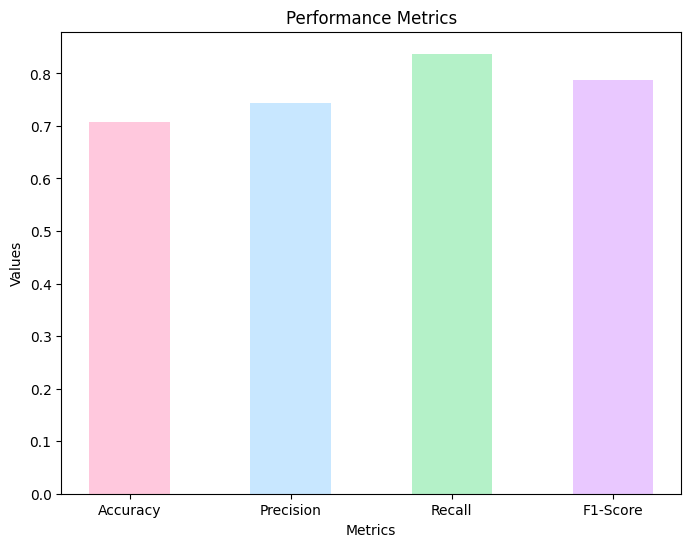

In [70]:
import matplotlib.pyplot as plt

# Define the performance metrics and their corresponding values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Define pastel colors for the bars
colors = ['#FFC8DD', '#C8E7FF', '#B4F1C8', '#E9C8FF']

# Create a bar plot with skinny bars and pastel colors
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=colors, width=0.5)

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# Display the plot
plt.show()

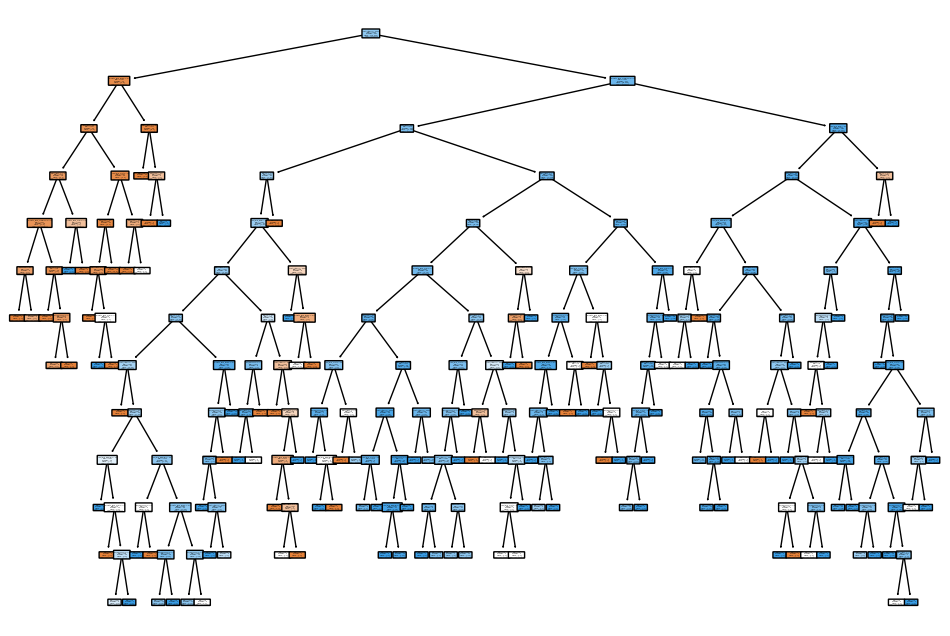

In [98]:
from sklearn.tree import plot_tree

# Extract the trained decision tree from your pipeline
decision_tree = final_pipeline['classifier']

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, feature_names=X_preprocessed.columns, class_names=['Not Approved', 'Approved'],
          filled=True, rounded=True)
plt.show()

In [ ]:
from sklearn.tree import export_text

# Extract the trained decision tree from your pipeline
decision_tree = final_pipeline['classifier']

# Get the textual representation of the decision tree
tree_text = export_text(decision_tree, feature_names=X_preprocessed.columns.tolist())

# Print the decision tree
print(tree_text)

In [85]:
single_row_data

Loan_ID              LP001002
Gender                      0
Married                     0
Dependents                  0
Education                   1
Self_Employed               0
ApplicantIncome          5849
CoapplicantIncome         0.0
LoanAmount                NaN
Loan_Amount_Term        360.0
Credit_History            1.0
Property_Area           Urban
Name: 0, dtype: object

In [100]:
single_row_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,0,0,0,1,0,5849,0.0,NaN,360.0,1.0,Urban


In [105]:
single_row_data = X.iloc[0]
single_row_df = pd.DataFrame([single_row_data])

single_instance_preprocessed = final_pipeline['preprocess'].transform(single_row_df)
# single_instance_preprocessed = drop_and_rename_columns(single_instance_preprocessed)

# # Now you can make a prediction
# single_pred = final_pipeline['classifier'].predict(single_instance_preprocessed)

# print("The prediction for the single instance is: ", single_pred)

ValueError: Columns must be same length as key

## 6. Deploy your model to AWS cloud and test it with PostMan, BASH or Python

AWS Key
Connect to my AWS - LHL_Key
- Access the .ssh folder: cd .ssh
- Connect to Amazon instance: ssh -i "LHL_Key.pem" ec2-user@ec2-15-223-50-219.ca-central-1.compute.amazonaws.com
- 

Activate Conda in AWS Environment:
- curl -O https://repo.anaconda.com/archive/Anaconda3-2021.11-Linux-x86_64.sh
- bash Anaconda3-2023.03-1-MacOSX-x86_64.sh
- source ~/anaconda3/bin/activate
- jupyter lab --ip 0.0.0.0 --port 8888 --no-browser
- Web browser: http://ec2-15-223-50-219.ca-central-1.compute.amazonaws.com:8888/lab

##### AWS 

In [ ]:
class PreprocessData(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Copy the input DataFrame to avoid modifying the original data
        X_transformed = X.copy()
        
        # Impute missing values
        X_transformed['Gender'].fillna('Unknown', inplace=True)
        X_transformed['Married'].fillna('No', inplace=True)
        X_transformed['Dependents'].fillna(0, inplace=True)
        X_transformed['Self_Employed'].fillna('No', inplace=True)
        X_transformed['Dependents'] = X_transformed['Dependents'].replace({'3+': 3})

        # Convert various columns to numeric values
        X_transformed['Gender'] = X_transformed['Gender'].replace({'Male': 0, 'Female': 1, 'Unknown': 2})
        X_transformed['Married'] = X_transformed['Married'].replace({'No': 0, 'Yes': 1})
        X_transformed['Education'] = X_transformed['Education'].replace({'Not Graduate': 0, 'Graduate': 1})
        X_transformed['Self_Employed'] = X_transformed['Self_Employed'].replace({'No': 0, 'Yes': 1})
        X_transformed['Dependents'] = X_transformed['Dependents'].astype(int)

        # Perform ordinal encoding for 'property_area'
        encoder = OrdinalEncoder()
        X_transformed['property_area'] = encoder.fit_transform(X_transformed[['Property_Area']])

        # Drop the original 'Property_Area' column
        X_transformed = X_transformed.drop('Property_Area', axis=1)

        columns_to_impute = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
        imputer = KNNImputer(n_neighbors=5)
        
        if X_transformed.shape[0] == 1:
            # Reshape the data to be 2D
            imputed_data = imputer.fit_transform(X_transformed[columns_to_impute].values.reshape(1, -1))
        else:
            imputed_data = imputer.fit_transform(X_transformed[columns_to_impute])
        
        X_transformed[columns_to_impute] = imputed_data

        # Convert the imputed values to a DataFrame
        imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute, index=X_transformed.index)

        # Merge the imputed values back into the original DataFrame
        X_transformed.drop(columns=columns_to_impute, inplace=True)
        X_transformed = pd.concat([X_transformed, imputed_df], axis=1)

        # Round 'LoanAmount' and 'Loan_Amount_Term' to the nearest whole number
        X_transformed['LoanAmount'] = X_transformed['LoanAmount'].round().astype(int)
        X_transformed['Loan_Amount_Term'] = X_transformed['Loan_Amount_Term'].round().astype(int)

        # Multiply values by 1000 for ApplicantIncome, CoapplicantIncome, and LoanAmount
        X_transformed['ApplicantIncome'] *= 12
        X_transformed['CoapplicantIncome'] *= 12
        X_transformed['LoanAmount'] *= 1000

        # Create categorical variable for Loan_Amount_Term
        X_transformed['Loan_Term_Category'] = pd.cut(X_transformed['Loan_Amount_Term'], bins=[0, 180, 360, np.inf], labels=['Short-term', 'Medium-term', 'Long-term'])

        # Perform ordinal encoding for 'Loan_Term_Category'
        encoder = OrdinalEncoder()
        X_transformed['loan_term_category'] = encoder.fit_transform(X_transformed[['Loan_Term_Category']])

        # Drop the original 'Loan_Term_Category' column
        X_transformed = X_transformed.drop('Loan_Term_Category', axis=1)

        return X_transformed

# class DropAndRenameColumns(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.columns_to_drop = ['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
#         self.column_mapping = {
#             'Gender': 'gender',
#             'Married': 'married',
#             'Dependents': 'dependents',
#             'Education': 'education',
#             'Self_Employed': 'self_employed',
#             'LoanAmount': 'loan_amount',
#             'Loan_Amount_Term': 'loan_amount_term',
#             'Credit_History': 'credit_history',
#             'Loan_Status': 'loan_status',
#             'property_area_Rural': 'property_area_rural',
#             'property_area_Semiurban': 'property_area_semiurban',
#             'property_area_Urban': 'property_area_urban',
#             'Loan_Term_Category_Short-term': 'loan_term_short',
#             'Loan_Term_Category_Medium-term': 'loan_term_medium',
#             'Loan_Term_Category_Long-term': 'loan_term_long',
#             'Loan_Status ': 'loan_status'
#         }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop(self.columns_to_drop, axis=1)
        X.rename(columns=self.column_mapping, inplace=True)
        return X

final_pipeline = Pipeline(steps=[
    ('preprocess', PreprocessData()),
    # ('drop_and_rename', DropAndRenameColumns()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

